In [11]:
from google.colab import userdata

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json
import os
import cv2

from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    print(line)
    return

# Paths

In [12]:
project_path = userdata.get('PATH_PROJECT')
dataset_path = os.path.join(project_path, 'dataset')
metadata_path = os.path.join(dataset_path, 'dataset_metadata.json')


# PSNR

## Check if we can pre-load all images

You can check the available memory in your Colab runtime using the `%shell` magic command and system commands.

In [13]:
%shell free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi       1.9Gi       6.6Gi       1.0Mi       4.1Gi        10Gi
Swap:             0B          0B          0B


In [14]:
image_dirs = ['clean', 'new', 'ref']
total_size_bytes = 0

for image_dir in image_dirs:
    dir_path = os.path.join(dataset_path, image_dir)
    if os.path.exists(dir_path):
        for filename in os.listdir(dir_path):
            if filename.endswith('.png'): # Assuming your images are PNG files
                file_path = os.path.join(dir_path, filename)
                total_size_bytes += os.path.getsize(file_path)

# Convert bytes to a more readable format (e.g., MB, GB)
total_size_mb = total_size_bytes / (1024 ** 2)
total_size_gb = total_size_bytes / (1024 ** 3)

print(f"Total size of image files: {total_size_bytes} bytes")
print(f"Total size of image files: {total_size_mb:.2f} MB")
print(f"Total size of image files: {total_size_gb:.2f} GB")

Total size of image files: 4190313 bytes
Total size of image files: 4.00 MB
Total size of image files: 0.00 GB


Pre-load all images

In [15]:
%%skip Skipping Parallel loading of the images

from joblib import Parallel, delayed
import time

def load_image(file_path, file_id):
    """Loads a single image and returns its ID and data."""
    img = cv2.imread(file_path)
    if img is not None:
        return file_id, img
    return None, None

# --- Example of parallelized loading ---
print("Parallel loading images...")
start_time = time.time()

image_dirs = ['clean', 'new', 'ref']
all_image_files = []

# Collect all image file paths and IDs
for image_dir in image_dirs:
    dir_path = os.path.join(dataset_path, image_dir)
    if os.path.exists(dir_path):
        for filename in os.listdir(dir_path):
            if filename.endswith('.png'):
                file_id = os.path.splitext(filename)[0]
                file_path = os.path.join(dir_path, filename)
                all_image_files.append((file_path, file_id))

# Parallelize the image loading
# n_jobs=-1 uses all available CPU cores
loaded_images_list = Parallel(n_jobs=-1)(
    delayed(load_image)(file_path, file_id) for file_path, file_id in all_image_files
    )

# Convert the list of tuples into a dictionary
parallel_loaded_images = {file_id: img for file_id, img in loaded_images_list if file_id is not None}

end_time = time.time()
print(f"Finished parallel loading {len(parallel_loaded_images)} images in {end_time - start_time:.2f} seconds.")

# You can now use the 'parallel_loaded_images' dictionary
# For example, to access an image:
# if '4547604' in parallel_loaded_images:
#     display(parallel_loaded_images['4547604'])

Skipping Parallel loading of the images


In [18]:
%%skip Comment out skip to load

# Pre-load images into dictionaries
print("Pre-loading images...")
image_dirs = [os.path.join(dataset_path, image_dir) for image_dir in ['clean', 'new', 'ref']]
images = dict()

for dir_path in image_dirs:
    if os.path.exists(dir_path):
        for filename in os.listdir(dir_path):
            file_id = os.path.splitext(filename)[0]
            file_path = os.path.join(dir_path, filename)
            img = cv2.imread(file_path)
            if img is not None:
                images[file_id] = img

print(f"Finished pre-loading {len(images)} images.")


Comment out skip to load


## Calculate PSNR

Calculating PSNR...
Finished calculating PSNR.


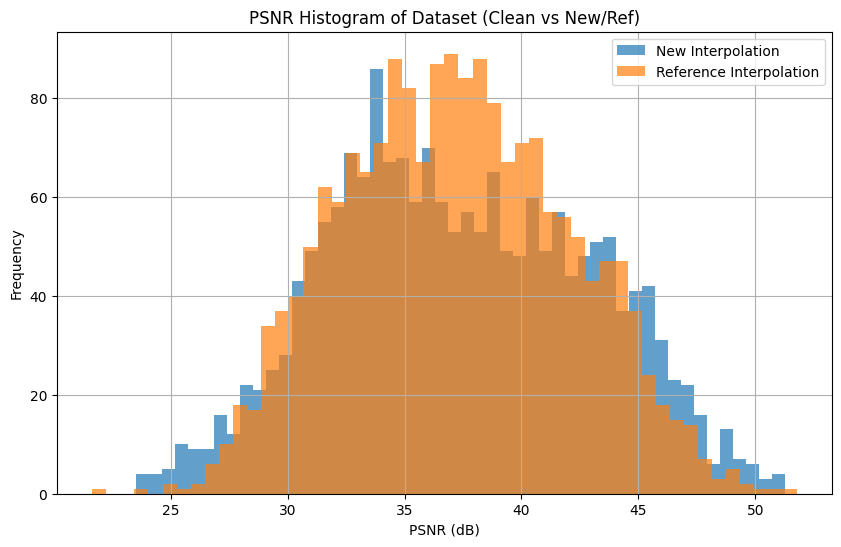

In [17]:
# from joblib import Parallel, delayed # We might not need parallelization if pre-loading is fast enough

def calculate_psnr(img1, img2):
    """Calculates the Peak Signal-to-Noise Ratio (PSNR) between two images."""
    # Ensure images are of the same size and type
    # Convert images to float32 for accurate calculations
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)

    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# List to store PSNR values
psnr_values_new = []
psnr_values_ref = []

# Iterate through metadata to find image pairs and calculate PSNR using pre-loaded images
meta = pd.read_json(metadata_path)

print("Calculating PSNR...")
for index, row in meta.iterrows():
    clean_id = str(row['clean_image'])
    distorted_id = str(row['distorted_image'])
    method = row['metadata']['method']

    img_clean = images.get(clean_id)
    img_distorted = images.get(distorted_id)

    if img_clean is not None and img_distorted is not None:
        psnr_val = calculate_psnr(img_clean, img_distorted)
        if method == 'new':
            psnr_values_new.append(psnr_val)
        elif method == 'ref':
            psnr_values_ref.append(psnr_val)
    # else:
        # print(f"Warning: Image pair not found for row {index}: clean_id={clean_id}, distorted_id={distorted_id}")


print("Finished calculating PSNR.")

# Plotting the histograms
plt.figure(figsize=(10, 6))
plt.hist(psnr_values_new, bins=50, alpha=0.7, label='New Interpolation')
plt.hist(psnr_values_ref, bins=50, alpha=0.7, label='Reference Interpolation')
plt.xlabel('PSNR (dB)')
plt.ylabel('Frequency')
plt.title('PSNR Histogram of Dataset (Clean vs New/Ref)')
plt.legend()
plt.grid(True)
plt.show()